# EP-LHb-RNN

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline
from matplotlib import rcParams

# rcParams['figure.figsize'] = [20, 4]
# rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Define model and optimizers

In [3]:
class EPLHb(nn.Module):
  def __init__(self, EP_size, LHb_size, DAN_size, 
               rnn: bool=False,
               fixed_sign: bool=False, real_circuit: bool=True, 
               prob_EP_to_LHb: float=1, prob_LHb_to_LHb: float=1, prob_LHb_to_DAN: float=1):
    super(EPLHb,self).__init__()
    
    # Initialize layers
    self.EP_to_LHb = nn.Linear(EP_size, LHb_size, bias=True)
    # nn.init.xavier_normal_(self.EP_to_LHb.weight)

    if rnn: self.LHb_RNN = nn.RNN(LHb_size, LHb_size, batch_first=True, bias=True)

    self.LHb_to_DAN = nn.Linear(LHb_size, DAN_size, bias=True)
    # nn.init.xavier_normal_(self.LHb_to_DAN.weight)
    # 
    with torch.no_grad():
      # Make EP to LHb sparse
      n_zeros = int((1-prob_EP_to_LHb) * self.EP_to_LHb.weight.numel())
      sparse_idx_EP = torch.randperm(self.EP_to_LHb.weight.numel())[:n_zeros]
      self.EP_to_LHb.weight.data.view(-1)[sparse_idx_EP] = 0
      # Make LHb to DAN sparse
      n_zeros = int((1-prob_LHb_to_DAN) * self.LHb_to_DAN.weight.numel())
      sparse_idx_LHb = torch.randperm(self.LHb_to_DAN.weight.numel())[:n_zeros]
      self.LHb_to_DAN.weight.data.view(-1)[sparse_idx_LHb] = 0
      
      if real_circuit: 
        # Make LHb to LHb all excitatory
        if rnn: self.LHb_RNN.weight_hh_l0.data = torch.abs(self.LHb_RNN.weight_hh_l0.data)
        # Make LHb to DAN all negative
        self.LHb_to_DAN.weight.data = -torch.abs(self.LHb_to_DAN.weight)
      
      # Turn into fixed sign (obey Dale's law)
      pos_neurons = {}
      neg_neurons = {}
      if fixed_sign:
        for name, param in self.named_parameters():
          if "weight" in name:
            # Find each neuron is excitatory or inhibitory
            pos_neurons[name] = torch.sum(param.data, axis=0) >= 0
            neg_neurons[name] = torch.sum(param.data, axis=0) < 0
            # Make all weights of that neuron excitatory or inhibitory
            param.data[:,pos_neurons[name]] = torch.sign(param[:,pos_neurons[name]])*param[:,pos_neurons[name]]
            param.data[:,neg_neurons[name]] = -torch.sign(param[:,neg_neurons[name]])*param[:,neg_neurons[name]]
    
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

    # Store information
    self.EP_size = EP_size
    self.LHb_size = LHb_size
    self.DAN_size = DAN_size
    self.rnn = rnn
    self.real_circuit = real_circuit
    self.fixed_sign = fixed_sign
    self.sparse_idx_EP = sparse_idx_EP
    self.sparse_idx_LHb = sparse_idx_LHb
    self.pos_neurons = pos_neurons
    self.neg_neurons = neg_neurons
    self.init_weights = self.record_params(calc_sign=False)

  def enforce_weights(self):
    with torch.no_grad():
      # Keep EP to LHb sparse
      self.EP_to_LHb.weight.data.view(-1)[self.sparse_idx_EP] = 0
      # Keep LHb to DAN sparse
      self.LHb_to_DAN.weight.data.view(-1)[self.sparse_idx_LHb] = 0
      
      if self.real_circuit:
        # Make LHb to LHb all excitatory
        if self.rnn: self.LHb_RNN.weight_hh_l0.data = torch.max(self.LHb_RNN.weight_hh_l0.data, 0*self.LHb_RNN.weight_hh_l0.data)
        # Make LHb to DAN all negative
        self.LHb_to_DAN.weight.data=torch.minimum(self.LHb_to_DAN.weight, 0*self.LHb_to_DAN.weight)

  def forward(self, input):
    LHB_act = self.EP_to_LHb(input)
    if self.rnn:
      # Initialize hidden state with zeros
      h0 = torch.zeros(1, input.size(0), self.LHb_size)
      hidden, _ = self.LHb_RNN(LHB_act, h0)
      LHB_out = hidden[:, -1, :]
    else: 
      LHB_out = self.tanh(LHB_act)

    DAN_act = self.LHb_to_DAN(LHB_out)
    DAN_out = self.tanh(DAN_act)

    return DAN_out
  
  def record_params(self, calc_sign: bool=True):
    # Save the network weights
    recorded_params = {}
    for name, param in self.named_parameters():
        if param.requires_grad:
          with torch.no_grad():
            cur_data = param.data.detach().cpu().clone()
            recorded_params[name] = (cur_data)
          
          if calc_sign:
            print(name)
            frac_pos = 100*(torch.sum(cur_data > 0)/cur_data.numel()).numpy()
            frac_zero = 100*(torch.sum(cur_data == 0)/cur_data.numel()).numpy()
            frac_neg = 100*(torch.sum(cur_data < 0)/cur_data.numel()).numpy()
            print(' Positive: ' + str(frac_pos) + '%; Negative: ' + str(frac_neg) + '%; Zero: ' + str(frac_zero) + '%')
            
    return recorded_params
  
  def train_model(self,num_epochs,train_loader,optimizer,
                  loss: str='MSE',
                  print_epoch: bool=True):

    # Define loss function
    training_loss = []
    if loss == 'MSE': loss_function = nn.MSELoss()
    elif loss in 'CrossEntropyLoss': loss_function = nn.CrossEntropyLoss()
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    # Train the network
    for epoch in range(num_epochs):
      for i, (data,labels) in enumerate(train_loader):
        optimizer.zero_grad()

        if self.rnn: data = data.view(-1,1, self.EP_size)
        elif data.ndim != 2: data = data.view(-1, self.EP_size)
        outputs = self(data)

        loss = loss_function(outputs.squeeze(), labels) #maybe need to flatten outputs
        training_loss.append(loss.data.cpu())

        loss.backward()
        optimizer.step(init_weights=list(self.init_weights.values()))
        self.enforce_weights()
        
      if print_epoch:
        print('Epoch [%d/%d], Loss: %.4f'  %(epoch+1, num_epochs, loss.data))
      # scheduler.step()

    return training_loss
  
  def test_model(self,test_loader):
    self.eval()      
    correct, total = 0, 0
    # Iterate through test dataset
    for data, labels in test_loader:
      if self.rnn: data = data.view(-1,1, self.EP_size)
      elif data.ndim != 2: data = data.view(-1, self.EP_size)
      outputs = self(data)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum()

    accuracy = 100 * correct / total
    return accuracy

In [4]:
class gd(torch.optim.Optimizer): 
    def __init__(self, params, lr=0.01, fixed_sign: bool = False): 
        defaults = dict(lr=lr, fixed_sign=fixed_sign) 
        super(gd, self).__init__(params, defaults) 
  
    def step(self, init_weights=None): 
        for group in self.param_groups: 
            for i, p in enumerate(group['params']): 
                if p.grad is None: 
                    continue
                p.data = p.data - group['lr']*p.grad.data

                if group['fixed_sign']:
                    flip_mask = init_weights[i].sign()*p.data.sign()<0
                    p.data[flip_mask] = 0

In [5]:
class adam(torch.optim.Optimizer): 
	def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, fixed_sign: bool = False): 
		defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, fixed_sign=fixed_sign)
		super(adam, self).__init__(params, defaults) 

	def step(self, init_weights=None): 
		for group in self.param_groups: 
			for i, p in enumerate(group['params']): 
				if p.grad is None: 
					continue
				grad = p.grad.data 
				if grad.is_sparse: 
					raise RuntimeError("Adam does not support sparse gradients") 

				state = self.state[p] 

				# State initialization 
				if len(state) == 0: 
					state["step"] = 0
					# Momentum: Exponential moving average of gradient values 
					state["exp_avg"] = torch.zeros_like(p.data) 
					# RMS prop componenet: Exponential moving average of squared gradient values 
					state["exp_avg_sq"] = torch.zeros_like(p.data) 

				exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"] 
				beta1, beta2 = group["betas"] 
				state["step"] += 1

				if group['weight_decay'] != 0: 
					grad = grad.add(p.data, alpha=group['weight_decay']) 

				# Decay the first and second moment running average coefficient
				exp_avg.lerp_(grad, 1 - beta1) # momentum
				exp_avg_sq.mul_(beta2).addcmul_(grad, grad.conj(), value=1-beta2) # rms
			
				bias_correction1 = 1 - beta1 ** state["step"] 
				bias_correction2 = 1 - beta2 ** state["step"] 

				step_size = group["lr"] / bias_correction1
				bias_correction2_sqrt = math.sqrt(bias_correction2)

				denom = (exp_avg_sq.sqrt() / bias_correction2_sqrt).add_(group["eps"])

				p.data.addcdiv_(exp_avg, denom, value=-step_size)
				
				if group["fixed_sign"]: 
					flip_mask = init_weights[i].sign()*p.data.sign()<0
					p.data[flip_mask] = 0

In [6]:
#@title Downloading MNIST data

train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

# val_data = dsets.MNIST(root = './data', train=False,
#                        transform=transforms.ToTensor(), download=True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

#@title Loading the data
batch_size = 100 # the size of input data took for one iteration

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

## Train RNN model

In [7]:
input_size = 784 # img_size = (28,28) ---> 28*28=784 in total
hidden_size = 100 # number of nodes at hidden layer
output_size = 10 # number of output classes discrete range [0,9]
num_epochs = 5 # 20 # number of times which the entire dataset is passed throughout the model
lr = 1e-3 # size of step

In [8]:
corelease_net = EPLHb(input_size,hidden_size,output_size,
                      fixed_sign=False,rnn=True,real_circuit=True)
if torch.cuda.is_available(): corelease_net.cuda()

# Initalize training details
loss_function = nn.CrossEntropyLoss()
# optimizer = gd(net.parameters(), lr=lr)
optimizer = adam(corelease_net.parameters(), lr=lr)
cr_training_loss = []

EP_to_LHb.weight
 Positive: 50.047194957733154%; Negative: 49.952805042266846%; Zero: 0.0%
EP_to_LHb.bias
 Positive: 43.99999976158142%; Negative: 56.00000023841858%; Zero: 0.0%
LHb_RNN.weight_ih_l0
 Positive: 50.33000111579895%; Negative: 49.66999888420105%; Zero: 0.0%
LHb_RNN.weight_hh_l0
 Positive: 100.0%; Negative: 0.0%; Zero: 0.0%
LHb_RNN.bias_ih_l0
 Positive: 41.999998688697815%; Negative: 57.999998331069946%; Zero: 0.0%
LHb_RNN.bias_hh_l0
 Positive: 52.99999713897705%; Negative: 46.99999988079071%; Zero: 0.0%
LHb_to_DAN.weight
 Positive: 0.0%; Negative: 100.0%; Zero: 0.0%
LHb_to_DAN.bias
 Positive: 50.0%; Negative: 50.0%; Zero: 0.0%


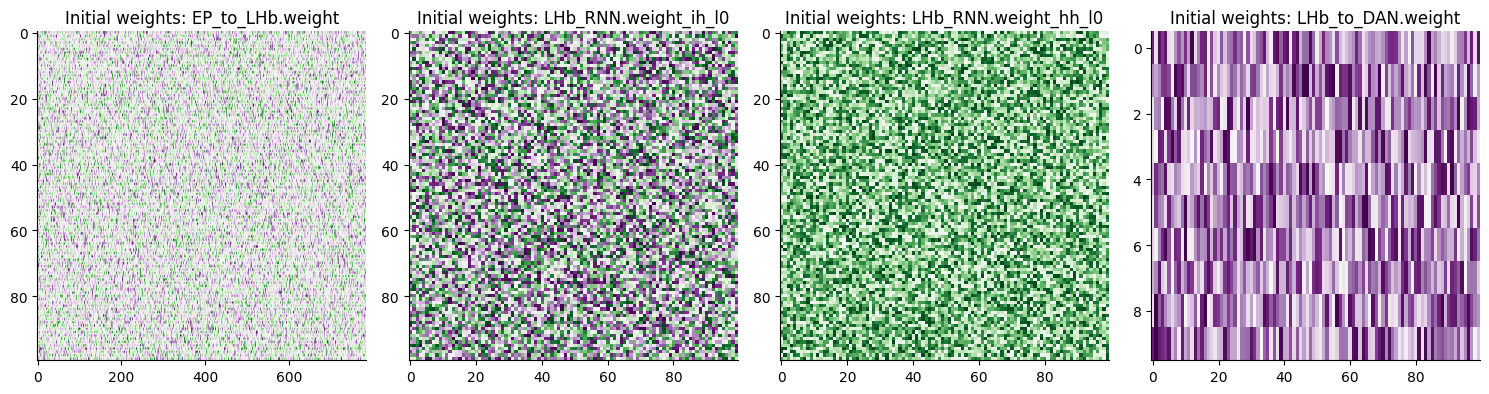

In [9]:
# Save the initial weights
initial_params_corelease = corelease_net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_corelease)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in initial_params_corelease.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Initial weights: ' + key)
    # plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

Epoch [1/5], Loss: 0.9390
Epoch [2/5], Loss: 0.9140
Epoch [3/5], Loss: 0.9058
Epoch [4/5], Loss: 0.8553
Epoch [5/5], Loss: 0.8513


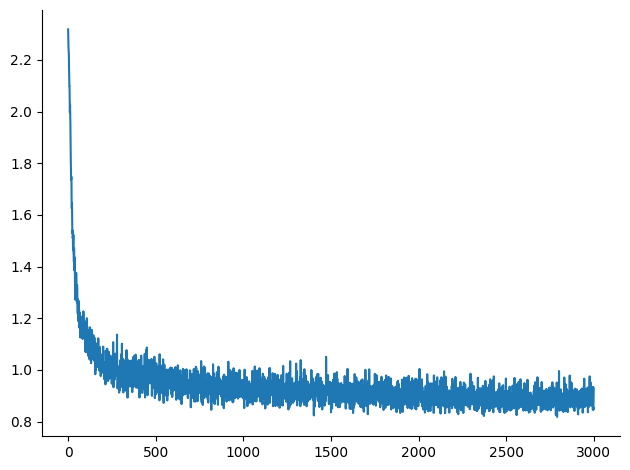

In [10]:
# Train the network
training_loss = corelease_net.train_model(num_epochs,train_loader,optimizer,loss='CrossEntropyLoss',print_epoch=True)
cr_training_loss.extend(training_loss)

# Plot training loss
plt.plot(cr_training_loss)

EP_to_LHb.weight
 Positive: 50.85969567298889%; Negative: 49.14030730724335%; Zero: 0.0%
EP_to_LHb.bias
 Positive: 54.00000214576721%; Negative: 46.00000083446503%; Zero: 0.0%
LHb_RNN.weight_ih_l0
 Positive: 50.56999921798706%; Negative: 49.43000078201294%; Zero: 0.0%
LHb_RNN.weight_hh_l0
 Positive: 100.0%; Negative: 0.0%; Zero: 0.0%
LHb_RNN.bias_ih_l0
 Positive: 67.00000166893005%; Negative: 33.000001311302185%; Zero: 0.0%
LHb_RNN.bias_hh_l0
 Positive: 72.00000286102295%; Negative: 28.00000011920929%; Zero: 0.0%
LHb_to_DAN.weight
 Positive: 0.0%; Negative: 93.99999976158142%; Zero: 5.999999865889549%
LHb_to_DAN.bias
 Positive: 20.000000298023224%; Negative: 80.0000011920929%; Zero: 0.0%


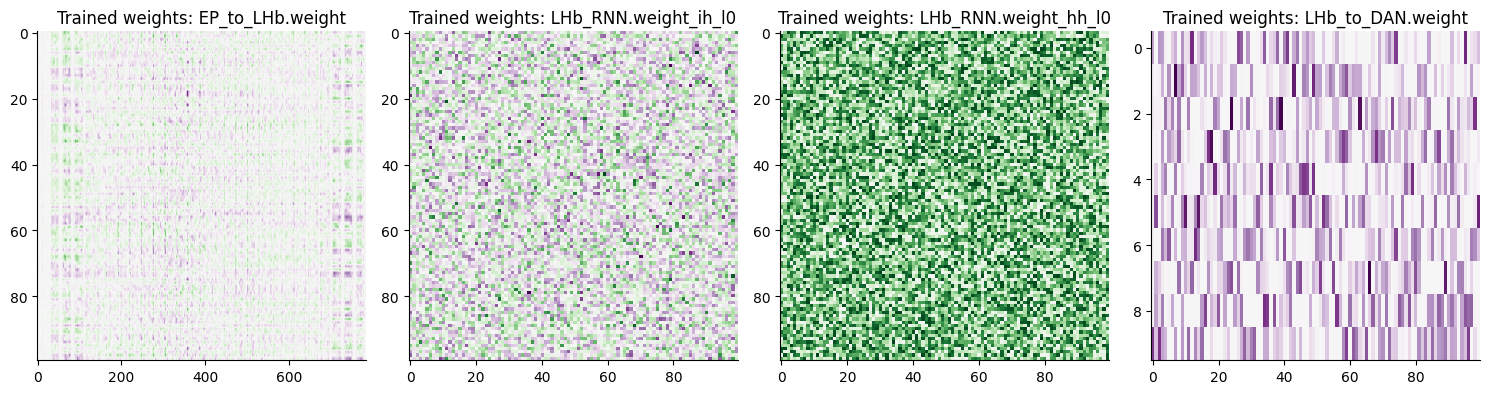

In [11]:
# Save the trianed parameters in paramList
trained_params_corelease = corelease_net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(trained_params_corelease)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in trained_params_corelease.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Trained weights: ' + key)
    # plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

EP_to_LHb.weight flipped:  37.180% (29149/78400)
EP_to_LHb.bias flipped:  46.000% (46/100)
LHb_RNN.weight_ih_l0 flipped:  22.820% (2282/10000)
LHb_RNN.weight_hh_l0 flipped:  0.000% (0/10000)
LHb_RNN.bias_ih_l0 flipped:  29.000% (29/100)
LHb_RNN.bias_hh_l0 flipped:  31.000% (31/100)
LHb_to_DAN.weight flipped:  0.000% (0/1000)
LHb_to_DAN.bias flipped:  30.000% (3/10)
EP_to_LHb.weight changed:  91.454% (71700/78400)
EP_to_LHb.bias changed:  100.000% (100/100)
LHb_RNN.weight_ih_l0 changed:  100.000% (10000/10000)
LHb_RNN.weight_hh_l0 changed:  0.000% (0/10000)
LHb_RNN.bias_ih_l0 changed:  100.000% (100/100)
LHb_RNN.bias_hh_l0 changed:  100.000% (100/100)
LHb_to_DAN.weight changed:  100.000% (1000/1000)
LHb_to_DAN.bias changed:  100.000% (10/10)


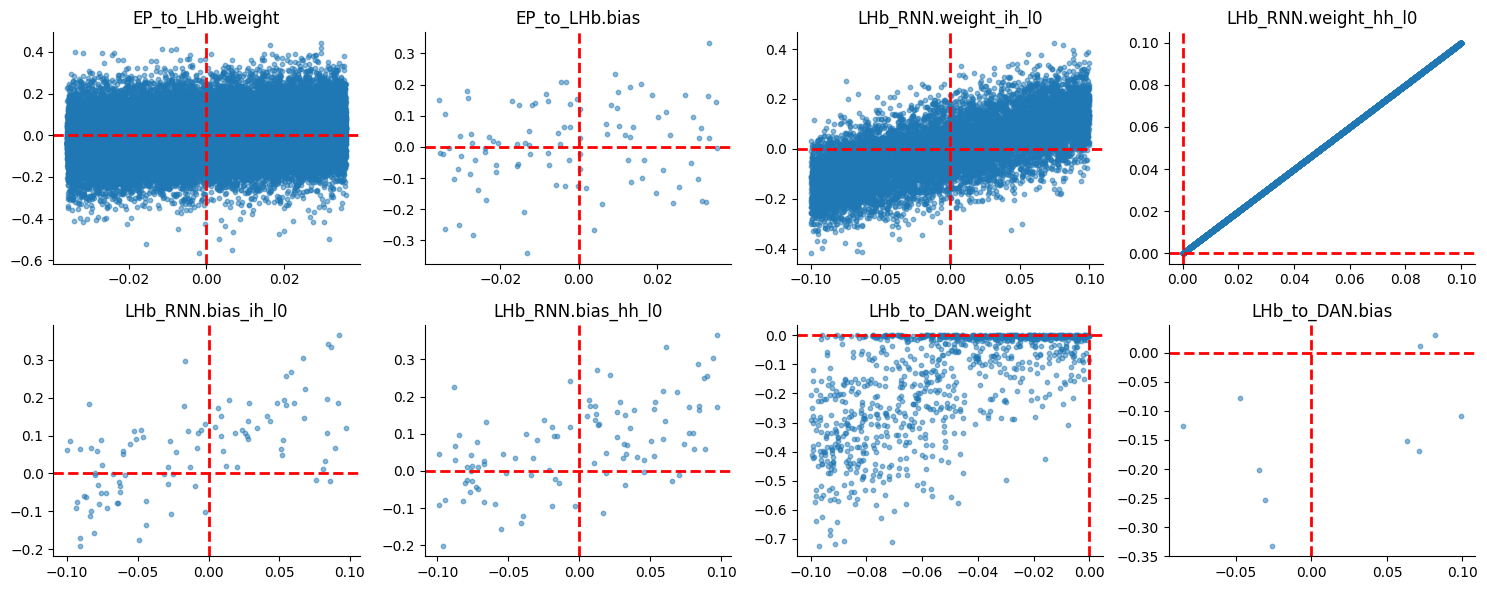

In [12]:
#@title What fraction of parameters flip sign?
for key in initial_params_corelease:
    n_weights=initial_params_corelease[key].numel()
    n_flip = (initial_params_corelease[key].sign()*trained_params_corelease[key].sign()<0).count_nonzero().item()
    print(key + ' flipped: % .3f%% (%d/%d)' %(100*n_flip/n_weights, n_flip, n_weights))

for key in initial_params_corelease:
    n_weights=initial_params_corelease[key].numel()
    n_changed = (initial_params_corelease[key] != trained_params_corelease[key]).count_nonzero().item()
    print(key + ' changed: % .3f%% (%d/%d)' %(100*n_changed/n_weights, n_changed, n_weights))

# Plot initial vs trained values

fig, axs = plt.subplots(2,int(len(trained_params_corelease)/2),figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)

ax = 0
for i, ax in enumerate(axs.flatten()):
    key = list(initial_params_corelease)[i]
    ax.scatter(initial_params_corelease[key].numpy(),trained_params_corelease[key].numpy(),s=10,alpha=0.5)
    ax.axhline(y=0, linewidth=2, color = 'r', ls='--')
    ax.axvline(x=0, linewidth=2, color = 'r', ls='--')
    ax.set_title(key)

plt.tight_layout()
plt.show()

## Fixed sign RNN model

In [13]:
fixed_sign_net = EPLHb(input_size,hidden_size,output_size,
                       rnn=True,fixed_sign=True,real_circuit=True)
if torch.cuda.is_available(): fixed_sign_net.cuda()

# Initalize training details
loss_function = nn.CrossEntropyLoss()
# optimizer = gd(fixed_sign_model.parameters(), lr=lr, fixed_sign=True)
fs_optimizer = adam(fixed_sign_net.parameters(), lr=lr, fixed_sign=True)
fs_training_loss = []

EP_to_LHb.weight
 Positive: 51.913267374038696%; Negative: 48.08673560619354%; Zero: 0.0%
EP_to_LHb.bias
 Positive: 52.99999713897705%; Negative: 46.99999988079071%; Zero: 0.0%
LHb_RNN.weight_ih_l0
 Positive: 44.999998807907104%; Negative: 55.000001192092896%; Zero: 0.0%
LHb_RNN.weight_hh_l0
 Positive: 100.0%; Negative: 0.0%; Zero: 0.0%
LHb_RNN.bias_ih_l0
 Positive: 47.999998927116394%; Negative: 51.99999809265137%; Zero: 0.0%
LHb_RNN.bias_hh_l0
 Positive: 46.99999988079071%; Negative: 52.99999713897705%; Zero: 0.0%
LHb_to_DAN.weight
 Positive: 0.0%; Negative: 100.0%; Zero: 0.0%
LHb_to_DAN.bias
 Positive: 69.9999988079071%; Negative: 30.000001192092896%; Zero: 0.0%


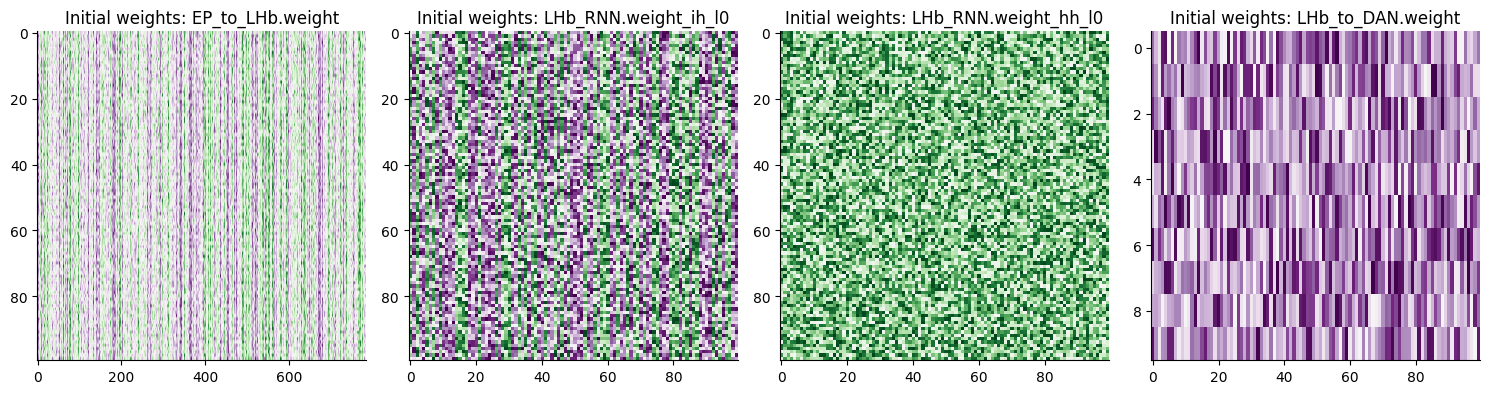

In [14]:
# Save the initial weights
initial_params_fixed = fixed_sign_net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_fixed)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in initial_params_fixed.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Initial weights: ' + key)
    # plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

In [15]:
# Train the network
training_loss = fixed_sign_net.train_model(num_epochs,train_loader,fs_optimizer,loss='CrossEntropyLoss',print_epoch=True)
fs_training_loss.extend(training_loss)

Epoch [1/5], Loss: 0.9519
Epoch [2/5], Loss: 1.0172
Epoch [3/5], Loss: 0.9044
Epoch [4/5], Loss: 0.8930
Epoch [5/5], Loss: 0.9606


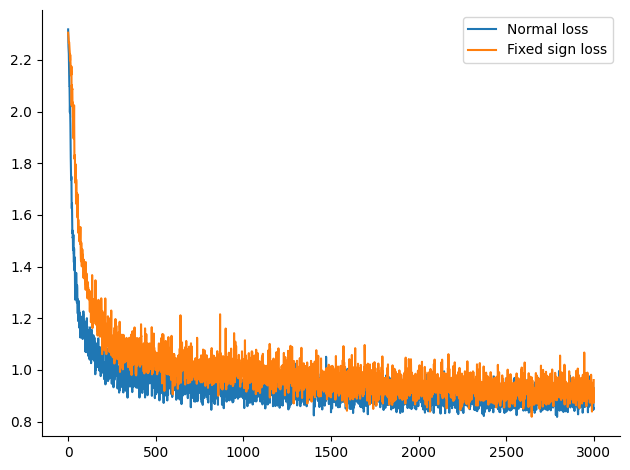

In [16]:
# Plot training loss history
plt.plot(cr_training_loss, label='Normal loss')
plt.plot(fs_training_loss, label='Fixed sign loss')
plt.legend()

# fig, axs = plt.subplots(1,2,figsize=(15, 5))
# axs[0].plot(cr_training_loss, label='Normal loss')
# axs[0].plot(fs_training_loss, label='Fixed sign loss')
# axs[0].legend()
# axs[1].plot(training_accuracy, label='Normal accuracy')
# axs[1].plot(fs_training_accuracy, label='Fixed sign accuracy')
# axs[1].legend()

EP_to_LHb.weight
 Positive: 49.1301029920578%; Negative: 45.39158046245575%; Zero: 5.47831617295742%
EP_to_LHb.bias
 Positive: 50.0%; Negative: 46.00000083446503%; Zero: 3.999999910593033%
LHb_RNN.weight_ih_l0
 Positive: 41.2200003862381%; Negative: 50.55000185966492%; Zero: 8.229999989271164%
LHb_RNN.weight_hh_l0
 Positive: 100.0%; Negative: 0.0%; Zero: 0.0%
LHb_RNN.bias_ih_l0
 Positive: 43.00000071525574%; Negative: 47.999998927116394%; Zero: 9.000000357627869%
LHb_RNN.bias_hh_l0
 Positive: 43.00000071525574%; Negative: 49.000000953674316%; Zero: 7.999999821186066%
LHb_to_DAN.weight
 Positive: 0.0%; Negative: 83.79999995231628%; Zero: 16.200000047683716%
LHb_to_DAN.bias
 Positive: 69.9999988079071%; Negative: 30.000001192092896%; Zero: 0.0%


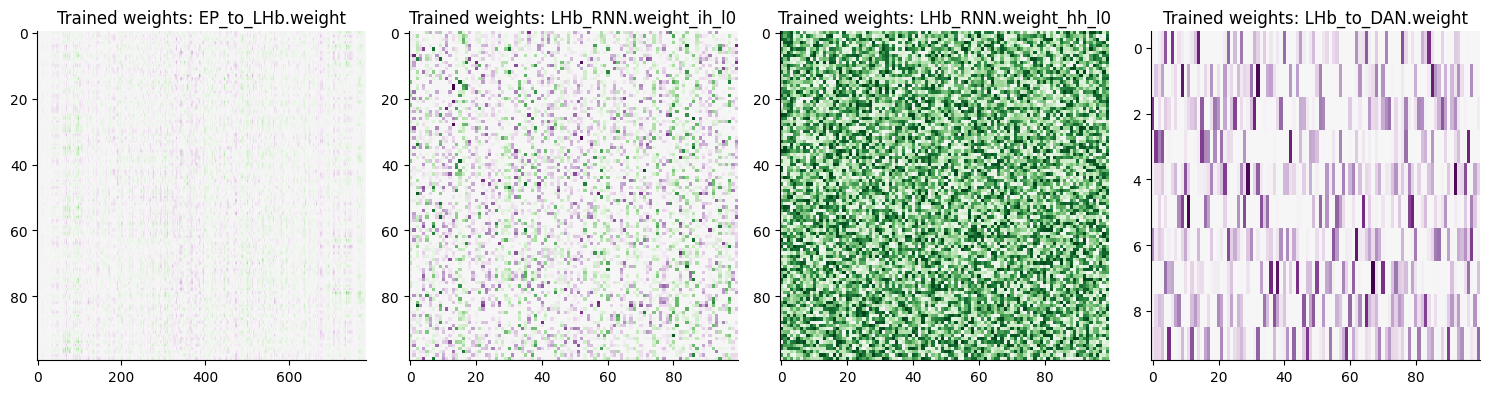

In [17]:
# Save the trianed parameters in paramList
trained_params_fixed = fixed_sign_net.record_params()
# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_fixed)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in trained_params_fixed.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Trained weights: ' + key)
    # plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

EP_to_LHb.weight flipped:  0.000% (0/78400)
EP_to_LHb.bias flipped:  0.000% (0/100)
LHb_RNN.weight_ih_l0 flipped:  0.000% (0/10000)
LHb_RNN.weight_hh_l0 flipped:  0.000% (0/10000)
LHb_RNN.bias_ih_l0 flipped:  0.000% (0/100)
LHb_RNN.bias_hh_l0 flipped:  0.000% (0/100)
LHb_to_DAN.weight flipped:  0.000% (0/1000)
LHb_to_DAN.bias flipped:  0.000% (0/10)
EP_to_LHb.weight changed:  91.454% (71700/78400)
EP_to_LHb.bias changed:  100.000% (100/100)
LHb_RNN.weight_ih_l0 changed:  100.000% (10000/10000)
LHb_RNN.weight_hh_l0 changed:  0.000% (0/10000)
LHb_RNN.bias_ih_l0 changed:  100.000% (100/100)
LHb_RNN.bias_hh_l0 changed:  100.000% (100/100)
LHb_to_DAN.weight changed:  100.000% (1000/1000)
LHb_to_DAN.bias changed:  100.000% (10/10)


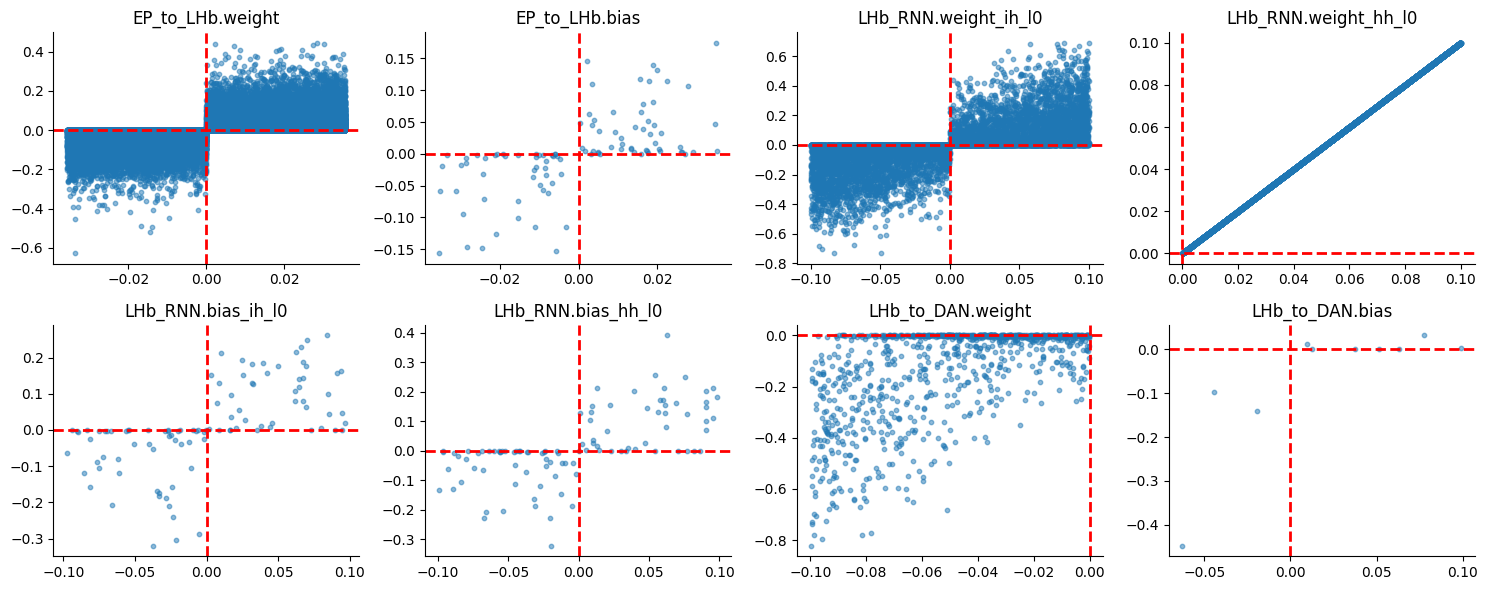

In [18]:
#@title What fraction of parameters flip sign?
for key in initial_params_fixed:
    n_weights=initial_params_fixed[key].numel()
    n_flip = (initial_params_fixed[key].sign()*trained_params_fixed[key].sign()<0).count_nonzero().item()
    print(key + ' flipped: % .3f%% (%d/%d)' %(100*n_flip/n_weights, n_flip, n_weights))

for key in initial_params_fixed:
    n_weights=initial_params_fixed[key].numel()
    n_changed = (initial_params_fixed[key] != trained_params_fixed[key]).count_nonzero().item()
    print(key + ' changed: % .3f%% (%d/%d)' %(100*n_changed/n_weights, n_changed, n_weights))

# Plot initial vs trained values

fig, axs = plt.subplots(2,int(len(trained_params_fixed)/2),figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)

ax = 0
for i, ax in enumerate(axs.flatten()):
    key = list(initial_params_fixed)[i]
    ax.scatter(initial_params_fixed[key].numpy(),trained_params_fixed[key].numpy(),s=10,alpha=0.5)
    ax.axhline(y=0, linewidth=2, color = 'r', ls='--')
    ax.axvline(x=0, linewidth=2, color = 'r', ls='--')
    ax.set_title(key)

plt.tight_layout()
plt.show()

## Weight change analysis

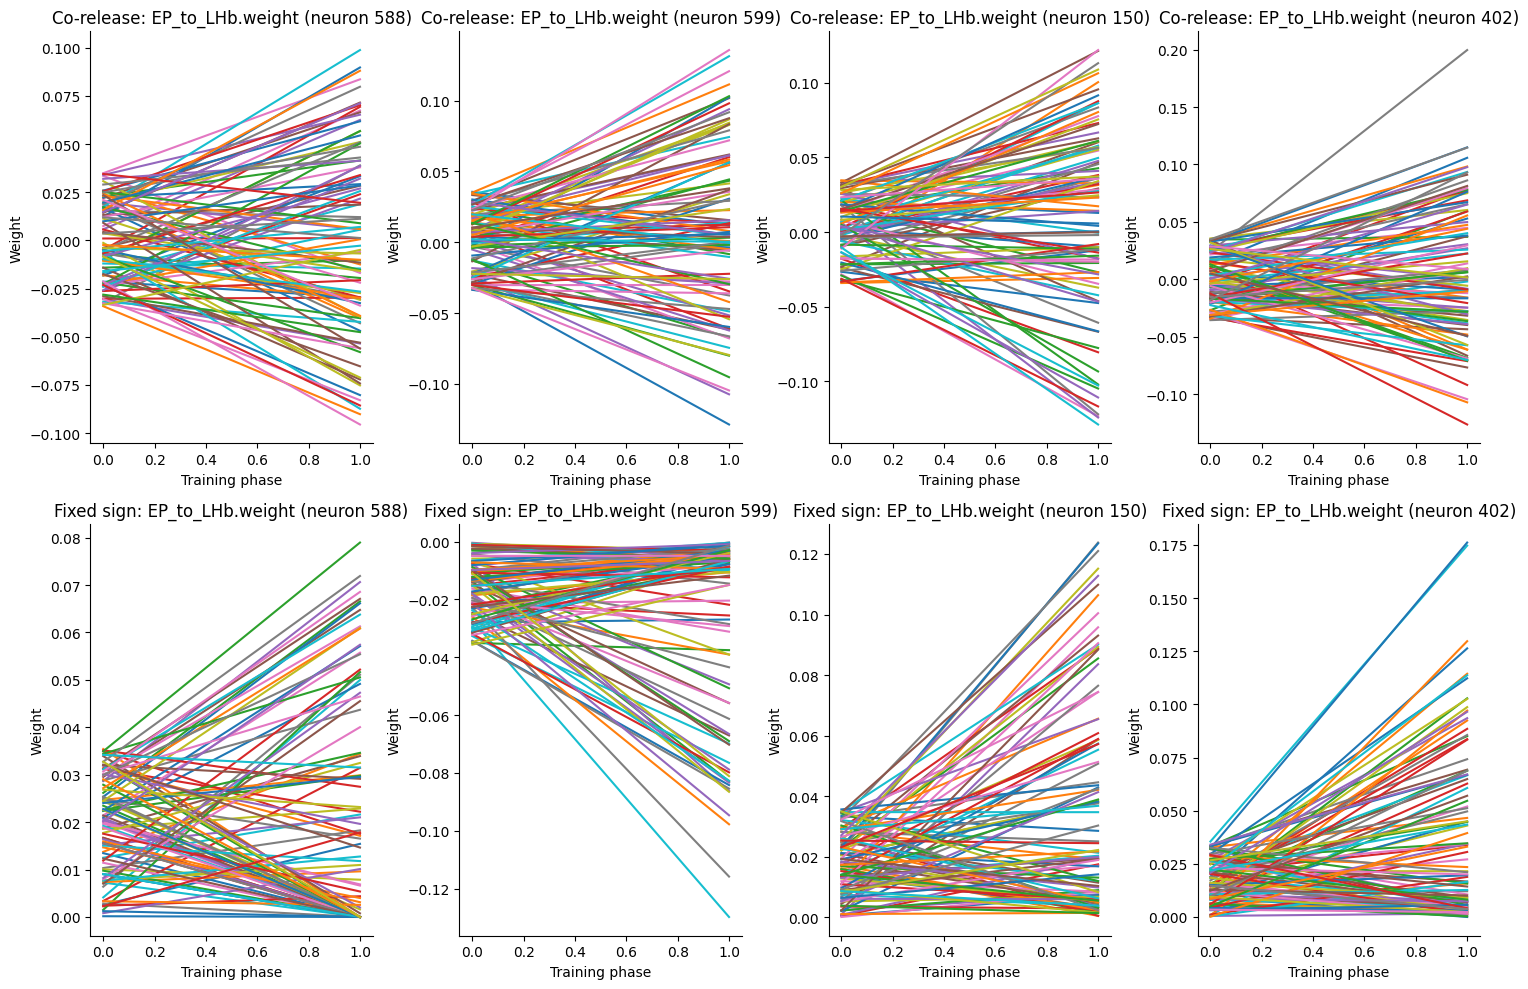

In [19]:
# Plot flipped EP neuron weight changes
n_row = 2
n_col = 4

fig, axs = plt.subplots(n_row,n_col,figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

key = list(initial_params_corelease)[0]
picked_neurons = torch.randint(1,input_size,(n_col,))

for i, neuron in enumerate(picked_neurons):
    weight_history_corelease = [initial_params_corelease[key][:,neuron].flatten(),
                                trained_params_corelease[key][:,neuron].flatten()]

    weight_history_fixed = [initial_params_fixed[key][:,neuron].flatten(),
                            trained_params_fixed[key][:,neuron].flatten()]

    axs.flatten()[i].plot(weight_history_corelease)
    axs.flatten()[i].set_xlabel('Training phase')
    axs.flatten()[i].set_ylabel('Weight')
    axs.flatten()[i].set_title('Co-release: %s (neuron %d)' %(key, neuron))
    axs.flatten()[i+n_col].plot(weight_history_fixed)
    axs.flatten()[i+n_col].set_xlabel('Training phase')
    axs.flatten()[i+n_col].set_ylabel('Weight')
    axs.flatten()[i+n_col].set_title('Fixed sign: %s (neuron %d)' %(key, neuron))

plt.tight_layout()
plt.show()

## Train multiple networks per condition

In [20]:
EP_size = 784 # img_size = (28,28) ---> 28*28=784 in total
LHb_size = 100 # number of nodes at hidden layer
DAN_size = 10 # number of output classes discrete range [0,9]
num_epochs = 10 # 20 # number of times which the entire dataset is passed throughout the model
lr = 1e-3 # size of step

prob_EP_to_LHb = 1
prob_LHb_to_LHb = 1
prob_LHb_to_DAN = 1

n_networks = 20 # number of networks to train

### Train multiple co-release models

In [24]:
cr_training_loss_summary = []

for i in range(1,n_networks+1):
    # Initialize a network
    net = EPLHb(EP_size,LHb_size,DAN_size,
                rnn=True,fixed_sign=False,real_circuit=True,
                prob_EP_to_LHb=prob_EP_to_LHb,prob_LHb_to_LHb=prob_LHb_to_LHb,prob_LHb_to_DAN=prob_LHb_to_DAN)
    initial_params = net.record_params(calc_sign=False)
    net_training_loss = []
    if torch.cuda.is_available(): net.cuda()

    # Train on original data
    optimizer = adam(net.parameters(), lr=lr, fixed_sign=False)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    training_loss = net.train_model(num_epochs,train_loader,optimizer,print_epoch=False,loss='CrossEntropyLoss')
    net_training_loss.extend(training_loss)

    # Train on flipped data
    # optimizer = adam(net.parameters(), lr=lr, fixed_sign=False)
    # training_loss = net.train_model(num_epochs,flip_loader,optimizer,print_epoch=False)
    # net_training_loss.extend(training_loss)

    cr_training_loss_summary.append(net_training_loss)
    print('Finished training co-release network %d/%d' %(i,n_networks))

# Convert list to numpy array
cr_training_loss_summary = np.array(cr_training_loss_summary)

# # Plot training loss for all network separately
# fig, axs = plt.subplots(n_networks,1,figsize=(15,3*n_networks))
# for i, ax in enumerate(axs.flatten()):
#     ax.plot(cr_training_loss_summary[i])
#     ax.set_title('Corelease # %d' %(i+1))

Finished training co-release network 1/20
Finished training co-release network 2/20
Finished training co-release network 3/20
Finished training co-release network 4/20
Finished training co-release network 5/20
Finished training co-release network 6/20
Finished training co-release network 7/20
Finished training co-release network 8/20
Finished training co-release network 9/20
Finished training co-release network 10/20
Finished training co-release network 11/20
Finished training co-release network 12/20
Finished training co-release network 13/20
Finished training co-release network 14/20
Finished training co-release network 15/20
Finished training co-release network 16/20
Finished training co-release network 17/20
Finished training co-release network 18/20
Finished training co-release network 19/20
Finished training co-release network 20/20


### Train multiple fixed sign models

In [26]:
fs_training_loss_summary = []

for i in range(1,n_networks+1):
    # Initialize a network
    net = EPLHb(EP_size,LHb_size,DAN_size,
                rnn=True,fixed_sign=True,real_circuit=True,
                prob_EP_to_LHb=prob_EP_to_LHb,prob_LHb_to_LHb=prob_LHb_to_LHb,prob_LHb_to_DAN=prob_LHb_to_DAN)
    initial_params = net.record_params(calc_sign=False)
    net_training_loss = []
    if torch.cuda.is_available(): net.cuda()

    # Train on original data
    optimizer = adam(net.parameters(), lr=lr, fixed_sign=True)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    training_loss = net.train_model(num_epochs,train_loader,optimizer,print_epoch=False,loss='CrossEntropyLoss')
    net_training_loss.extend(training_loss)

    # Train on flipped data
    # optimizer = adam(net.parameters(), lr=lr, fixed_sign=True)
    # training_loss = net.train_model(num_epochs,flip_loader,optimizer,print_epoch=False)
    # net_training_loss.extend(training_loss)

    fs_training_loss_summary.append(net_training_loss)
    print('Finished training fixed sign network %d/%d' %(i,n_networks))

# Convert list to numpy array
fs_training_loss_summary = np.array(fs_training_loss_summary)

# # Plot training loss for all network separately
# fig, axs = plt.subplots(n_networks,1,figsize=(15,3*n_networks))
# for i, ax in enumerate(axs.flatten()):
#     ax.plot(fs_training_loss_summary[i])
#     ax.set_title('Fixed # %d' %(i+1))

### Train fixed sign without negative output

In [ ]:
fs_posneg_training_loss_summary = []

for i in range(1,n_networks+1):
    # Initialize a network
    net = EPLHb(EP_size,LHb_size,DAN_size,
                rnn=True, fixed_sign=True, real_circuit=False,
                prob_EP_to_LHb=prob_EP_to_LHb,prob_LHb_to_LHb=prob_LHb_to_LHb,prob_LHb_to_DAN=prob_LHb_to_DAN)
    initial_params = net.record_params(calc_sign=False)
    net_training_loss = []
    if torch.cuda.is_available(): net.cuda()

    # Train on original data
    optimizer = adam(net.parameters(), lr=lr, fixed_sign=True)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    training_loss = net.train_model(num_epochs,train_loader,optimizer,print_epoch=False,loss='CrossEntropyLoss')
    net_training_loss.extend(training_loss)

    # Train on flipped data
    # optimizer = adam(net.parameters(), lr=lr, fixed_sign=True)
    # training_loss = net.train_model(num_epochs,flip_loader,optimizer,print_epoch=False)
    # net_training_loss.extend(training_loss)

    fs_posneg_training_loss_summary.append(net_training_loss)
    print('Finished training fixed sign network %d/%d' %(i,n_networks))

# Convert list to numpy array
fs_posneg_training_loss_summary = np.array(fs_posneg_training_loss_summary)

# # Plot training loss for all network separately
# fig, axs = plt.subplots(n_networks,1,figsize=(15,3*n_networks))
# for i, ax in enumerate(axs.flatten()):
#     ax.plot(fs_training_loss_summary[i])
#     ax.set_title('Fixed # %d' %(i+1))

### Plot summary

In [ ]:
mean_cr_loss = np.mean(cr_training_loss_summary,axis=0)
sem_cr_loss = stats.sem(cr_training_loss_summary)
mean_fs_loss = np.mean(fs_training_loss_summary,axis=0)
sem_fs_loss = stats.sem(fs_training_loss_summary)
mean_fs_posneg_loss = np.mean(fs_posneg_training_loss_summary,axis=0)
sem_fs_posneg_loss = stats.sem(fs_posneg_training_loss_summary)

# Plot
x = np.linspace(1,mean_cr_loss.shape[0],num=mean_cr_loss.shape[0],dtype='int32')
plt.plot(mean_cr_loss, label='Co-release')
plt.fill_between(x,mean_cr_loss+sem_cr_loss,mean_cr_loss-sem_cr_loss,alpha=0.2)
plt.plot(mean_fs_loss, label='Fixed sign')
plt.fill_between(x,mean_fs_loss+sem_fs_loss,mean_fs_loss-sem_fs_loss,alpha=0.2)
plt.plot(mean_fs_posneg_loss, label='Fixed sign without neg output')
plt.fill_between(x,mean_fs_posneg_loss+sem_fs_posneg_loss,mean_fs_posneg_loss-sem_fs_posneg_loss,alpha=0.2)

plt.xlabel('Trianing epochs')
plt.ylabel('Training loss')
plt.legend()
plt.show()